In [3]:
!pip install pandas
!pip install numpy
!pip install geopandas
!pip install matplotlib
!pip  install geopandas
import pandas as pd
import numpy as np
import sqlite3
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt

# Os Dataframes Regiao e Estado foram unidos pela coluna em comum "CodigoRegiao", em seguida a coluna "UF" foi renomeada para "uf" pra que o dataframe pudesse
# pudesse ser juntada com o dataframe "casos" pela coluna em comum "uf", formando assim o dataframe "casosbrasil"

# O DataFrame casosbrasil por sua vez possuia na coluna "nomelocalidade" dados faltantes para o tipo "state", porém há na coluna "uf" a informação do respectivo estado
# para aquele "tipo", sendo assim foi feita uma máscara booleana com TRUE para valores nulos e FALSE para valores não nulos para a coluna "nomelocalidade"
# em seguida usamos a função loc para transformar as linhas NaN na coluna "nomelocalidade" de acordo com a mask criada anteriormente. As linhas com booleano TRUE foram transfomadas
# usando o comando loc para pegar as linhas linhas com booleano TRUE da coluna "uf" 

# Em seguida calculamos as mortes por estado e morte por cidade e subtraimos um pelo outro para análisar a magnitude das diferenças de lançamento de óbitos
# O resultado é que a estados tem mais óbitos lançados do que cidade. Porém, ao comparar a soma de casos e a soma de óbitos por tipo Estado e por tipo Cidade na função "casoss"
# ao comparar com os dados oficiais do painel de COVID-19 no Brasil do ministério da Saúde, reparamos que os dados batem exatamente para cada dia
# Segue o site do painel para comparação https://infoms.saude.gov.br/extensions/covid-19_HTML_DIARIO/covid-19_HTML_DIARIO.html 
# Por exemplo, ao selecionar Regiao = Sudeste, UF= SP e Cidade = SP temos no painel para o dia 13/08/2020 7,06k de casos novos e 142 novos óbitos, igual ao dataframe gerado na função "casoss"
# Ao selecionar Regiao = Sudeste, UF = SP vimos que os dados também batem para estados
# Sendo assim decidimos deixar os dados como estão e somar os casosnovos e mortesnovas junto com as linhas com valores negativos também

   ---------------------------------------- 0.0/11.0 MB ? eta -:--:--
   ------------ --------------------------- 3.4/11.0 MB 20.4 MB/s eta 0:00:01
   ------------------------------- -------- 8.7/11.0 MB 22.3 MB/s eta 0:00:01
   ---------------------------------------- 11.0/11.0 MB 20.2 MB/s  0:00:00
   ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
   --------------- ------------------------ 5.0/12.8 MB 24.8 MB/s eta 0:00:01
   ------------------------- -------------- 8.1/12.8 MB 19.7 MB/s eta 0:00:01
   -------------------------------------- - 12.3/12.8 MB 19.8 MB/s eta 0:00:01
   ---------------------------------------- 12.8/12.8 MB 18.5 MB/s  0:00:00

   ---------------------------------------- 0/4 [pytz]
   ---------------------------------------- 0/4 [pytz]
   ---------------------------------------- 0/4 [pytz]
   ---------------------------------------- 0/4 [pytz]
   ---------------------------------------- 0/4 [pytz]
   --------------------------------------

In [26]:
import sqlite3
import pandas as pd

con = sqlite3.connect("DadosCOVID/dados.db")

pd.read_sql_query(
    "SELECT name FROM sqlite_master WHERE type='table';",
    con
)
import os

os.path.getsize("DadosCOVID/dados.db")


0

In [27]:
# Pegando Dados
casos = pd.read_csv( "DadosCOVID/casos.csv", sep = ";", decimal = ",")

con  = sqlite3.connect("DadosCOVID/base.db")
Regiao = pd.read_sql_query("select * from Regiao;",con) 
Estado = pd.read_sql_query("select * from Estado;", con)
# Criando DataFrame base com Região + Estado
base = pd.merge(Regiao, Estado, on = "CodigoRegiao")

# Vendo a estrutura do dataframe
casos.info()
# Criando Dataframe Casos + Base 
base.rename(columns = {'UF':'uf'}, inplace = True) #mudando nome da coluna no dataframe base para ficar igual ao do dataframe casos
casosbrasil = pd.merge(casos, base, on = "uf")

# Verificando a estrutura do novo Dataframe
casosbrasil.info()

# Verificando quantidade dados faltantes nas colunas
num_nan = casosbrasil.isna().sum()
print(num_nan)
# Preenchendo dados faltantes da coluna nomelocalidade (dados de estado) de acordo com a coluna uf, data e tipo
mask = casosbrasil['nomelocalidade'].isnull() #Identificar os valores faltantes na coluna 'nomelocalidade'
casosbrasil.loc[mask, 'nomelocalidade'] = casosbrasil.loc[mask, 'uf'] #
# Verificando quantidade de dados faltantes novamente
num_nan = casosbrasil.isna().sum()
print(num_nan)

# Calculando diferença de óbitos entre Estados e Cidades
mortes_por_tipo_estado = casosbrasil[casosbrasil["tipo"] == "state"]["mortesnovas"].sum()
mortes_por_tipo_cidade = casosbrasil[casosbrasil["tipo"] == "city"]["mortesnovas"].sum()
# Separando as somas por tipo ("city" e "state")
mortes = mortes_por_tipo_estado - mortes_por_tipo_cidade
print("Diferença de Óbitos entre Estado e Cidade",mortes)


def casoss(casosbrasil):
    brasilcovid = pd.DataFrame(casosbrasil)
    
    # Casos acumulados por Cidade, Estado e Região. E mortes/cidade
    brasilcovid = casosbrasil[casosbrasil["tipo"] == "city"].groupby(["NomeRegiao", "uf", "nomelocalidade", "data" ,"populacao"])[["casosnovos", "mortesnovas"]].sum().reset_index()
    # Somando casos para estado (acumulados e por dia)
    casos_estado = casosbrasil[casosbrasil["tipo"] == "state"].groupby("uf")["casosnovos"].sum().reset_index()
    casos_dia_estados = casosbrasil[casosbrasil["tipo"] == "state"].groupby(["data","uf"])["casosnovos"].sum().reset_index().rename(columns={"casosnovos": "casos_dia_estados"})
    # Calculando morte por dia para estados
    morte_dia_estados = casosbrasil[casosbrasil["tipo"] == "state"].groupby(["data", "uf"])["mortesnovas"].sum().reset_index().rename(columns={"mortesnovas": "mortes_dia_estados"})

    # Juntando dataframe casos_estado com brasil covid
    brasilcovid = brasilcovid.merge(casos_estado, on='uf', how='left')
    brasilcovid = brasilcovid.merge(casos_dia_estados)
    brasilcovid = brasilcovid.merge(morte_dia_estados)
    
    # Renomeando colunas
    brasilcovid.columns = ['NomeRegiao', 'uf', 'nomelocalidade',"data", "populacao", "casos_cidade", "mortes_cidade", "casos_estado","casos_dia_estados", "morte_dia_estados"]
    
    # Casos Região
    brasilcovid['casos_regiao'] = brasilcovid.drop_duplicates(subset=['NomeRegiao', 'uf']).groupby("NomeRegiao")["casos_estado"].transform("sum")
    brasilcovid['casos_regiao'] = brasilcovid.groupby('NomeRegiao')['casos_regiao'].ffill()

    # Óbitos acumulados Estado e Região
    brasilcovid['mortes_estado'] = brasilcovid.groupby("uf")["mortes_cidade"].transform("sum")
    brasilcovid['mortes_regiao'] = brasilcovid.groupby("NomeRegiao")["mortes_cidade"].transform("sum")
    
    # População Brasil
    brasilcovid["populacaoBrasil"] = casosbrasil[casosbrasil["tipo"] == "state"]["populacao"].unique().sum()
    
    # Cálculo da letalidade por cidade, estado e região
    brasilcovid["letalidade_cidade"] = brasilcovid["mortes_cidade"]/brasilcovid["casos_cidade"]
    brasilcovid["letalidade_estado"] = brasilcovid["mortes_estado"]/brasilcovid["casos_estado"]
    brasilcovid["letalidade_regiao"] = brasilcovid["mortes_regiao"]/brasilcovid["casos_regiao"]
    
    # Cálculo da mortalidade por cidade, estado e regiao
    brasilcovid["mortalidade_cidade"] = brasilcovid["mortes_cidade"]/brasilcovid["populacao"]
    brasilcovid["mortalidade_estado"] = brasilcovid["mortes_estado"]/brasilcovid["populacao"]
    brasilcovid["mortalidade_regiao"] = brasilcovid["mortes_regiao"]/brasilcovid["populacao"]
    
    # Porcentagem de casos por cidade, estado e Região para Plotar Mapa Brasil e Gráfico Setores
    # Cidades 
    brasilcovid['porcentagem_cas_cidades'] = (brasilcovid['casos_cidade'] / brasilcovid['casos_cidade'].unique().sum()) * 100 # Porcentagem
    # Estados
    brasilcovid['porcentagem_cas_estados'] = (brasilcovid['casos_estado'] / brasilcovid['casos_estado'].unique().sum()) * 100 # Porcentagem
    # Regiao
    brasilcovid['porcentagem_cas_regiao'] = brasilcovid['casos_regiao'] / brasilcovid['casos_regiao'].unique().sum() * 100
    
    # Reordenando colunas
    nova_ordem = ["NomeRegiao","uf", "nomelocalidade", "data", "populacao", "casos_cidade", "porcentagem_cas_cidades", "mortes_cidade", "letalidade_cidade", "mortalidade_cidade",
                  "casos_estado","casos_dia_estados", "porcentagem_cas_estados", "mortes_estado","morte_dia_estados", "letalidade_estado", "mortalidade_estado",
                  "casos_regiao", "porcentagem_cas_regiao", "mortes_regiao", "letalidade_regiao", "mortalidade_regiao"]
    brasilcovid = brasilcovid.reindex(columns=nova_ordem)


    return brasilcovid
    

brasilcovid = casoss(casosbrasil)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 785372 entries, 0 to 785371
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   nomelocalidade  779995 non-null  object 
 1   codigoibge      782100 non-null  float64
 2   data            785372 non-null  object 
 3   populacao       782100 non-null  float64
 4   tipo            785372 non-null  object 
 5   uf              785372 non-null  object 
 6   casosnovos      785372 non-null  int64  
 7   mortesnovas     785372 non-null  int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 47.9+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 785372 entries, 0 to 785371
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   nomelocalidade  779995 non-null  object 
 1   codigoibge      782100 non-null  float64
 2   data            785372 non-null  object 
 3   populacao       78210

In [28]:
x = brasilcovid.groupby("uf")["mortes_cidade"].sum().reset_index()
x

,uf,mortes_cidade
0,AC,654
1,AL,2044
2,AM,4000
3,AP,702
4,BA,6552
5,CE,8918
6,DF,2922
7,ES,3436
8,GO,4505
9,MA,3714


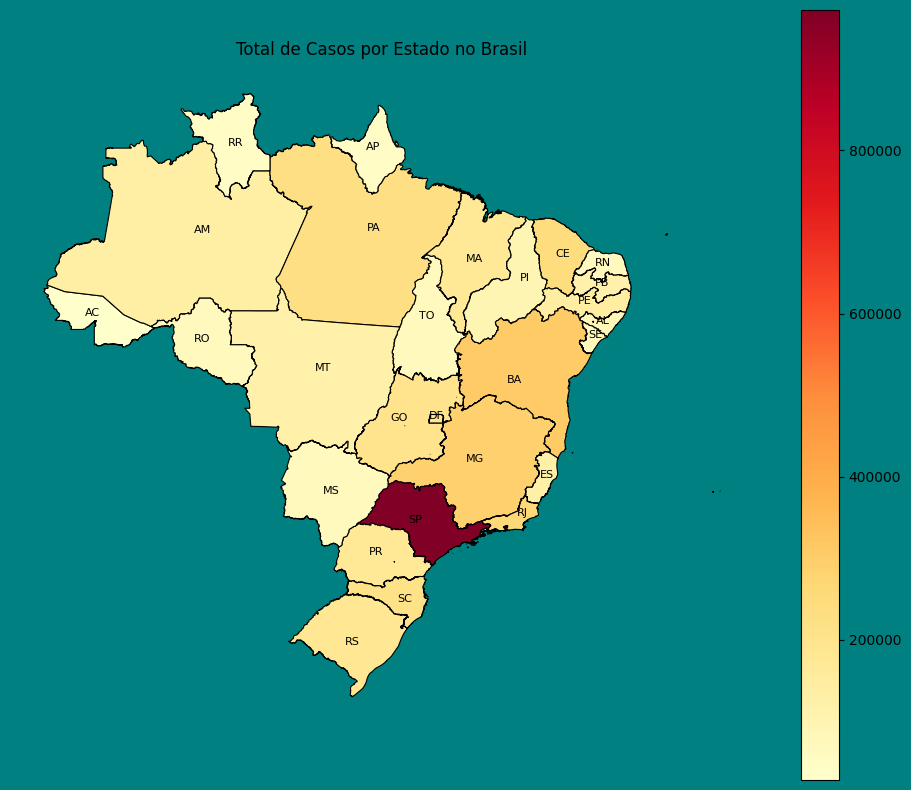

In [33]:
def mapa_casos_brasil(brasilcovid, titulo_mapa="Total de Casos por Estado no Brasil", cmap='YlOrRd', figsize=(12, 10)):
    shapefile_path = "C:\\Users\\Samsung\\Desktop\\Análise Covid\\Shapefile\\BR_UF_2022.shp"  # Substitua pelo caminho do seu arquivo shapefile do Brasil por Estado no Brasil    
    # Removendo duplicatas do dataframe original pela coluna uf
    brasilcovid_unique = brasilcovid.drop_duplicates(subset='uf')

    # Carregar o shapefile do Brasil
    brasil = gpd.read_file(shapefile_path)
    
    # Renomeando coluna de Estado
    coluna_shapefile = "SIGLA_UF"
    brasil.rename(columns={coluna_shapefile: "uf"}, inplace=True)

    # Mesclar os dados dos estados com as informações geográficas do shapefile
    brasil = brasil.merge(brasilcovid_unique, on="uf", how="left")

    # Plotar o mapa
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    brasil.plot(column="casos_estado", cmap=cmap, linewidth=0.8, ax=ax, edgecolor='black', legend=True)
    ax.set_title(titulo_mapa)
    ax.axis('off')

    # Adicionar rótulos dos estados no mapa
    for idx, row in brasil.iterrows():
        estado = row['uf']
        # Encontrar um ponto representativo dentro do polígono do estado
        point = row['geometry'].representative_point()
        x, y = point.x, point.y
        ax.annotate(estado, (x, y), fontsize=8, ha='center', color='black')

    # Mudar a cor de fundo da figura principal
    fig.patch.set_facecolor('teal')

    plt.show()

mapa_casos_brasil(brasilcovid)
    

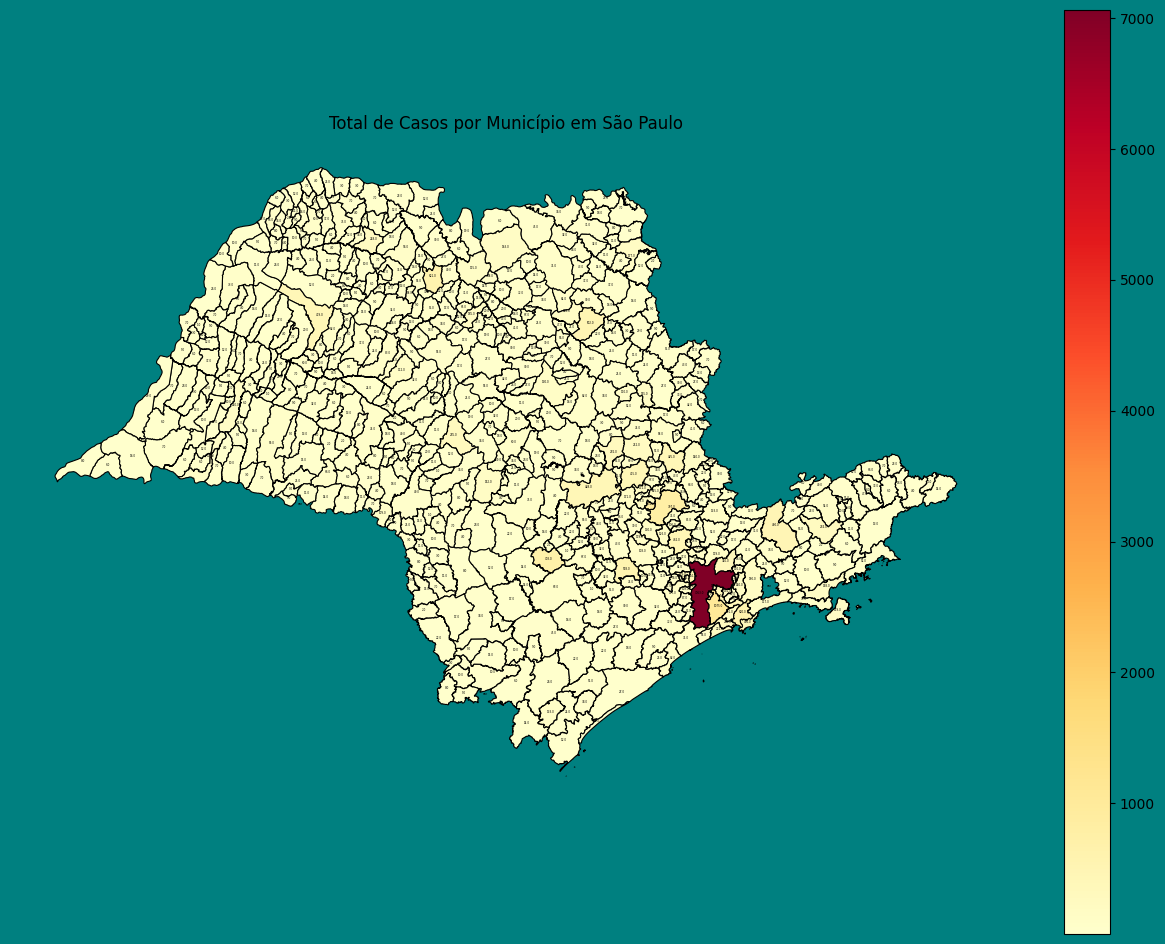

In [34]:
def mapa_covid_estado(brasilcovid, titulo_mapa="Total de Casos por Município em São Paulo", cmap='YlOrRd', figsize=(16, 12)):
    # Pegando casos únicos das cidades de SP quando a coluna uf == SP
    casos_SP = brasilcovid[brasilcovid['uf'] == 'SP'].groupby('nomelocalidade')['casos_cidade'].max().reset_index()
    
    # Carregar o shapefile do Brasil
    shapefile_path = "C:\\Users\\Samsung\\Desktop\\Análise Covid\\ShapefileSP\\SP_Municipios_2022.shp"  # Substitua pelo caminho do seu arquivo shapefile do Brasil por Estado no Brasil    
    brasil_Estados = gpd.read_file(shapefile_path)
    
    # Renomeando coluna de Município
    coluna_shapefile = "NM_MUN"
    brasil_Estados.rename(columns={coluna_shapefile: "nomelocalidade"}, inplace=True)

    # Mesclar os dados dos municípios com as informações geográficas do shapefile
    brasil_Estados = brasil_Estados.merge(casos_SP, on="nomelocalidade", how="left")

    # Plotar o mapa
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    brasil_Estados.plot(column="casos_cidade", cmap=cmap, linewidth=0.8, ax=ax, edgecolor='black', legend=True)
    ax.set_title(titulo_mapa)
    ax.axis('off')

    # Adicionar rótulos dos municípios no mapa
    for idx, row in brasil_Estados.iterrows():
        cidade = row['casos_cidade']
        # Encontrar um ponto representativo dentro do polígono do município
        point = row['geometry'].representative_point()
        x, y = point.x, point.y
        ax.annotate(cidade, (x, y), fontsize=2, ha='center', color='black')

    # Mudar a cor de fundo da figura principal
    fig.patch.set_facecolor('teal')

    plt.show()

# Chamar a função para plotar o mapa
mapa_covid_estado(brasilcovid)

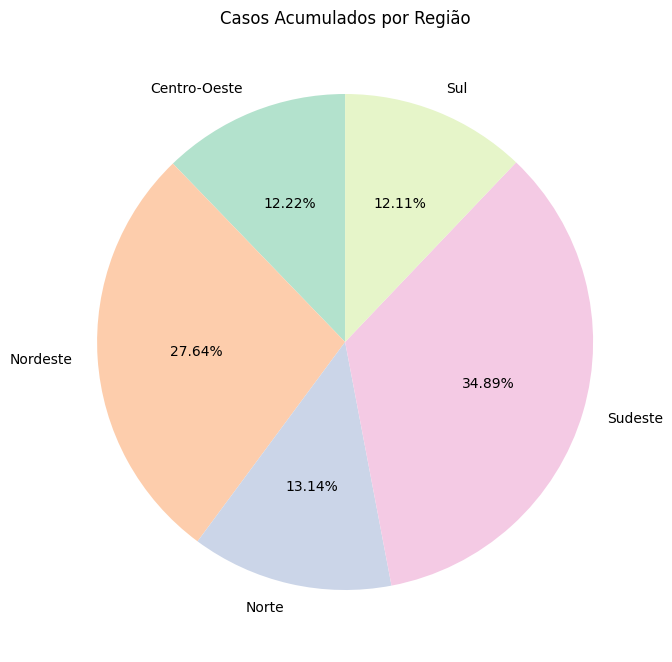

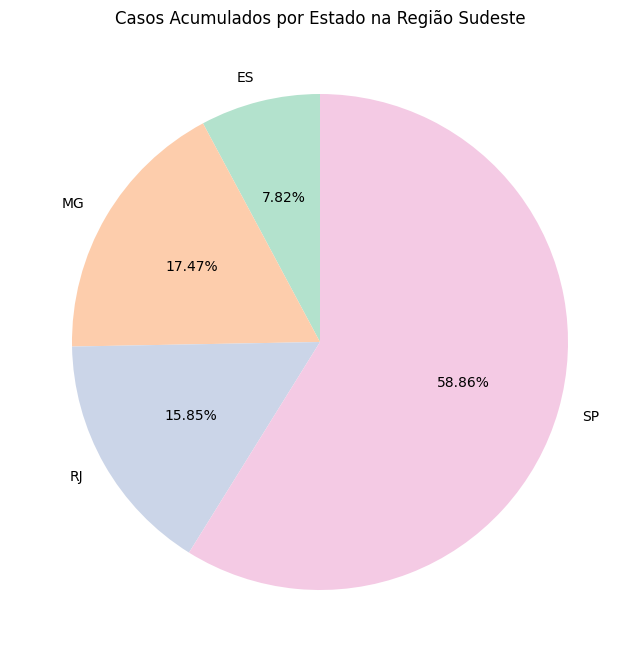

In [35]:
def grafico_setores(brasilcovid, figsize=(8, 10), autopct="%1.2f%%", startangle=135, colors=plt.cm.Pastel2.colors):
    fig, ax = plt.subplots(figsize=figsize)
    
    ax.pie(brasilcovid.groupby(['NomeRegiao'])['porcentagem_cas_regiao'].unique(), labels= brasilcovid['NomeRegiao'].unique(), autopct='%1.2f%%', startangle=90, colors = colors)
    ax.set_title('Casos Acumulados por Região')
    plt.show()
    
    # Gráfico por Região Sudeste
    fig, ax = plt.subplots(figsize=figsize)
    regiao_sudeste = brasilcovid[brasilcovid['NomeRegiao'] == 'Sudeste']

    ax.pie(regiao_sudeste.groupby(['uf'])['porcentagem_cas_estados'].max(), labels= regiao_sudeste['uf'].unique(), autopct='%1.2f%%', startangle=90, colors = colors)
    ax.set_title('Casos Acumulados por Estado na Região Sudeste')
    plt.show()
    
    

# Gráfico de Casos Acumulados por Estado
grafico_setores(brasilcovid)

In [36]:
# 10 cidaddes do brasil com maior taxa de casos confirmados

def dez_cidades_taxa(brasilcovid, order = "taxa"):
    top_10_maiores_taxas = brasilcovid[["uf", "nomelocalidade", "casos_cidade", "populacao", "letalidade_cidade", "mortalidade_cidade"]]
    top_10_maiores_taxas["taxa"] = top_10_maiores_taxas["casos_cidade"]/top_10_maiores_taxas["populacao"]
    top_10_maiores_taxas = top_10_maiores_taxas.nlargest(10, 'taxa')
    top_10_maiores_taxas = top_10_maiores_taxas.sort_values(by=order)
    return(top_10_maiores_taxas)
dez_cidades_taxa(brasilcovid)

C:\Users\Samsung\AppData\Local\Temp\ipykernel_20040\3996169687.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_10_maiores_taxas["taxa"] = top_10_maiores_taxas["casos_cidade"]/top_10_maiores_taxas["populacao"]


,uf,nomelocalidade,casos_cidade,populacao,letalidade_cidade,mortalidade_cidade,taxa
268498,PI,Joaquim Pires,271,14354.0,0.000000,0.000000,0.018880
325893,AM,Carauari,539,28294.0,0.000000,0.000000,0.019050
173209,MA,Fernando Falcão,201,10360.0,0.000000,0.000000,0.019402
258265,PI,Bertolínia,110,5501.0,0.009091,0.000182,0.019996
276474,PI,Porto,264,12568.0,0.000000,0.000000,0.021006
326343,AM,Coari,1802,85097.0,0.002775,0.000059,0.021176
407095,MG,Bandeira,111,4795.0,0.000000,0.000000,0.023149
553000,SP,Guareí,456,18520.0,0.000000,0.000000,0.024622
684601,RS,Charrua,115,3279.0,0.000000,0.000000,0.035072
553004,SP,Guareí,703,18520.0,0.000000,0.000000,0.037959


In [37]:
# 10 cidades do Estado de SP com maior taxa de casos confirmados
def dez_cidades_taxa_SP(brasilcovid, order = "taxa"):
    top_10__SP = brasilcovid[brasilcovid["uf"] == "SP"]
    top_10__SP = top_10__SP[["uf", "nomelocalidade", "casos_cidade", "populacao", "letalidade_cidade", "mortalidade_cidade"]]
    top_10__SP["taxa"] = top_10__SP["casos_cidade"]/top_10__SP["populacao"]
    top_10__SP = top_10__SP.nlargest(10, 'taxa')
    top_10__SP = top_10__SP.sort_values(by=order)
    return(top_10__SP)
dez_cidades_taxa_SP(brasilcovid)

,uf,nomelocalidade,casos_cidade,populacao,letalidade_cidade,mortalidade_cidade,taxa
579143,SP,Onda Verde,27,4381.0,0.0,0.0,0.006163
613176,SP,Três Fronteiras,36,5807.0,0.0,0.0,0.006199
614606,SP,Uru,8,1165.0,0.0,0.0,0.006867
564089,SP,Jaci,58,7067.0,0.0,0.0,0.008207
540786,SP,Catiguá,65,7804.0,0.0,0.0,0.008329
584856,SP,Piacatu,60,5980.0,0.0,0.0,0.010033
609816,SP,Taiúva,59,5566.0,0.0,0.0,0.010600
609821,SP,Taiúva,67,5566.0,0.0,0.0,0.012037
553000,SP,Guareí,456,18520.0,0.0,0.0,0.024622
553004,SP,Guareí,703,18520.0,0.0,0.0,0.037959


In [41]:
# Casos por Estado
def casos_por_estado(brasilcovid, order = "uf"):
    casos_estado = brasilcovid.groupby(["uf"])[["casos_estado","mortes_estado","letalidade_estado","mortalidade_estado"]].first()
    return(casos_estado)
casos_estado = casos_por_estado(brasilcovid)


In [42]:
def preparar_dados_para_grafico():
    # Agrupando por 'data' e 'uf' e obtendo valores únicos de "casos_dia_estados" e "morte_dia_estados"
    dispersao = brasilcovid.groupby(["data", "uf"])["casos_dia_estados"].unique().reset_index()
    morte_dia_estados = brasilcovid.groupby(["data", "uf"])["morte_dia_estados"].unique().reset_index()
    dispersao = dispersao.merge(morte_dia_estados)
    
    # Convertendo a coluna 'data' para o tipo datetime
    dispersao['data'] = pd.to_datetime(dispersao['data'], format='%d/%m/%Y')
    
    # Ordenando os dados pela 'data'
    dispersao = dispersao.sort_values('data')
    
    # Criando uma nova coluna com a contagem progressiva de dias
    dispersao['contagem_datas'] = dispersao.groupby('data').ngroup() + 1
    
    # Agrupando por 'data', 'uf' e obtendo a média de 'contagem_datas' e 'casos_dia_estados' e 'morte_dia_estados
    dispersao = dispersao.groupby(["data", "uf"])[["contagem_datas", "casos_dia_estados", "morte_dia_estados"]].sum().reset_index()
    
    # Criando dataframe com dados para SP
    dispersao_sp = dispersao[dispersao["uf"]=="SP"]
    
    # Removendo coluna UF
    
    # Agrupando por 'data' e 'contagem_datas' e somando 'casos_dia_estados'
    dispersao = dispersao.groupby(["data", "contagem_datas"])[["casos_dia_estados", "morte_dia_estados"]].sum().reset_index()
    
    return dispersao, dispersao_sp

# Chamada da função com o DataFrame 'brasilcovid'
dispersao, dispersao_sp = preparar_dados_para_grafico()

In [43]:
dispersao.info()
dispersao_sp.info()

dispersao['casos_dia_estados'] = dispersao['casos_dia_estados'].astype(float)
dispersao_sp['casos_dia_estados'] = dispersao_sp['casos_dia_estados'].astype(float)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216 entries, 0 to 215
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   data               216 non-null    datetime64[ns]
 1   contagem_datas     216 non-null    int64         
 2   casos_dia_estados  216 non-null    object        
 3   morte_dia_estados  216 non-null    object        
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 6.9+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 216 entries, 0 to 5355
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   data               216 non-null    datetime64[ns]
 1   uf                 216 non-null    object        
 2   contagem_datas     216 non-null    int64         
 3   casos_dia_estados  216 non-null    object        
 4   morte_dia_estados  216 non-null    object        
dtypes: date

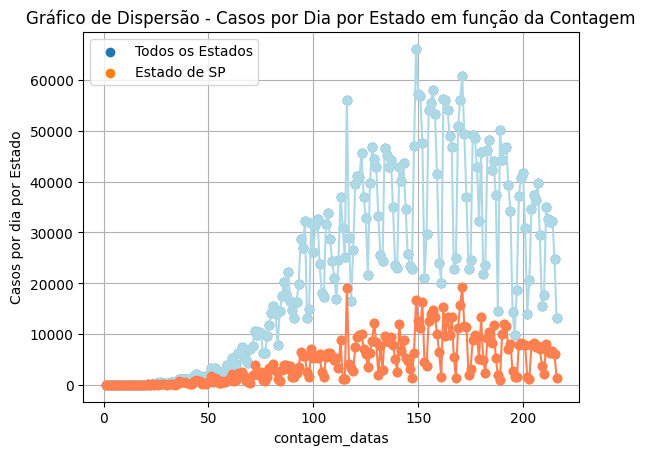

In [44]:
def plotar_grafico_dispersao_conectado(dispersao, dispersao_sp):
    # Criando o gráfico de dispersão para todos os casos por dia do Brasil
    plt.scatter(dispersao['contagem_datas'], dispersao['casos_dia_estados'], label='Todos os Estados')

    # Criando o gráfico de dispersão apenas para o estado de São Paulo
    plt.scatter(dispersao_sp['contagem_datas'], dispersao_sp['casos_dia_estados'], label='Estado de SP')

    # Conectando os pontos para todos os estados com a cor lightblue
    plt.plot(dispersao['contagem_datas'], dispersao['casos_dia_estados'], linestyle='-', marker='o', color='lightblue')

    # Conectando os pontos apenas para o estado de São Paulo com a cor coral
    plt.plot(dispersao_sp['contagem_datas'], dispersao_sp['casos_dia_estados'], linestyle='-', marker='o', color='coral')

    # Configurações do gráfico
    plt.xlabel('contagem_datas')
    plt.ylabel('Casos por dia por Estado')
    plt.title('Gráfico de Dispersão - Casos por Dia por Estado em função da Contagem')
    plt.legend()

    # Mostrando o gráfico
    plt.grid(True)
    plt.show()

plotar_grafico_dispersao_conectado(dispersao, dispersao_sp)

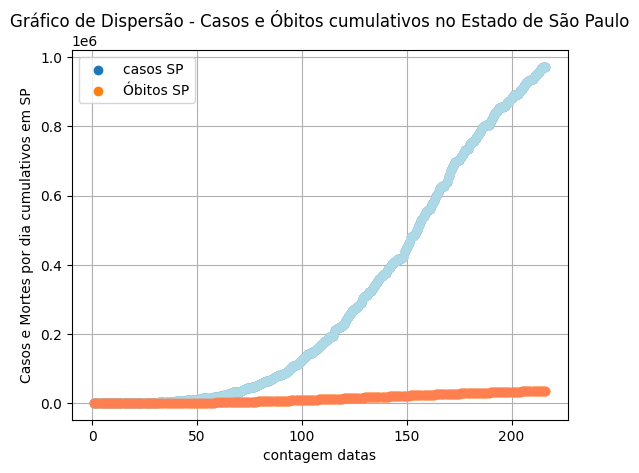

In [45]:
def dispersao_casos_obitos_SP(dispersao_sp):
    dispersao_sp['contagem_datas'] = dispersao_sp['contagem_datas'].astype(float)
    dispersao_sp['casos_dia_estados'] = dispersao_sp['casos_dia_estados'].astype(float)
    dispersao_sp['morte_dia_estados'] = dispersao_sp['morte_dia_estados'].astype(float)
    dispersao_sp['casos_dia_sp_cumulativo'] = dispersao_sp['casos_dia_estados'].cumsum()
    dispersao_sp['morte_dia_sp_cumulativo'] = dispersao_sp['morte_dia_estados'].cumsum()
    
    # Criando o gráfico de dispersão para todos os casos por dia do Brasil
    plt.scatter(dispersao_sp['contagem_datas'], dispersao_sp['casos_dia_sp_cumulativo'], label='casos SP')

    # Criando o gráfico de dispersão apenas para o estado de São Paulo
    plt.scatter(dispersao_sp['contagem_datas'], dispersao_sp['morte_dia_sp_cumulativo'], label='Óbitos SP')

    # Conectando os pontos para casos e óbitos em São Paulo
    plt.plot(dispersao_sp['contagem_datas'], dispersao_sp['casos_dia_sp_cumulativo'], linestyle='-', marker='o', color='lightblue')
    plt.plot(dispersao_sp['contagem_datas'], dispersao_sp['morte_dia_sp_cumulativo'], linestyle='-', marker='o', color='coral')

    # Configurações do gráfico
    plt.xlabel('contagem datas')
    plt.ylabel('Casos e Mortes por dia cumulativos em SP')
    plt.title('Gráfico de Dispersão - Casos e Óbitos cumulativos no Estado de São Paulo')
    plt.legend()

    # Mostrando o gráfico
    plt.grid(True)
    plt.show()

dispersao_casos_obitos_SP(dispersao_sp)


Análise de Tendência Brasil: Estável (-6.31%)
Análise de Tendência SP: Estável (-8.54%)


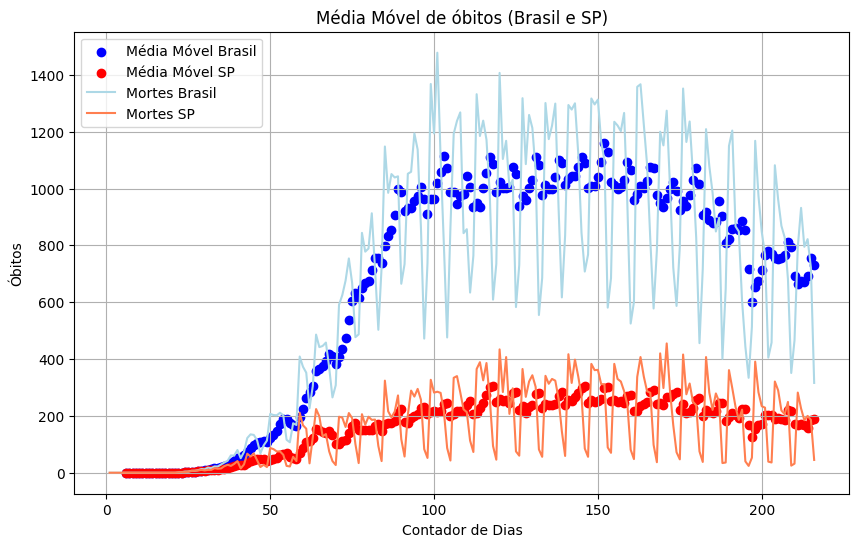

In [46]:
def plotar_dispersao_media_movel_e_mortes(dispersao, dispersao_sp):
    # Função interna para calcular a média móvel
    def calcular_media_movel(data):
        return data.rolling(window=6).mean()

    # Calcula a média móvel para óbitos do Brasil e de São Paulo
    dispersao['media_movel_brasil'] = calcular_media_movel(dispersao['morte_dia_estados'])
    dispersao_sp['media_movel_sp'] = calcular_media_movel(dispersao_sp['morte_dia_estados'])

    # Cria uma figura para o gráfico com tamanho 10x6 polegadas
    plt.figure(figsize=(10, 6))


    # Plota os pontos de dispersão para a média móvel do Brasil e de São Paulo
    plt.scatter(dispersao['contagem_datas'], dispersao['media_movel_brasil'], label='Média Móvel Brasil', color='blue')
    plt.scatter(dispersao_sp['contagem_datas'], dispersao_sp['media_movel_sp'], label='Média Móvel SP', color='red')

    # Plota a linha para o número diário de mortes do Brasil e de São Paulo
    plt.plot(dispersao['contagem_datas'], dispersao['morte_dia_estados'], label='Mortes Brasil', color='lightblue')
    plt.plot(dispersao_sp['contagem_datas'], dispersao_sp['morte_dia_estados'], label='Mortes SP', color='coral')

    # Calcula a variação percentual entre o último dia e o décimo quarto dia anterior
    variacao_brasil = ((dispersao['media_movel_brasil'].iloc[-1] - dispersao['media_movel_brasil'].iloc[-15]) / dispersao['media_movel_brasil'].iloc[-15]) * 100
    variacao_sp = ((dispersao_sp['media_movel_sp'].iloc[-1] - dispersao_sp['media_movel_sp'].iloc[-15]) / dispersao_sp['media_movel_sp'].iloc[-15]) * 100

    # Determina o status da tendência com base na variação percentual
    status_brasil = "Estável" if abs(variacao_brasil) <= 15 else "Em crescimento" if variacao_brasil > 15 else "Em queda"
    status_sp = "Estável" if abs(variacao_sp) <= 15 else "Em crescimento" if variacao_sp > 15 else "Em queda"

    # Exibe o status da tendência
    print(f"Análise de Tendência Brasil: {status_brasil} ({variacao_brasil:.2f}%)")
    print(f"Análise de Tendência SP: {status_sp} ({variacao_sp:.2f}%)")

    # Define rótulos e título do gráfico
    plt.xlabel('Contador de Dias')
    plt.ylabel('Óbitos')
    plt.title('Média Móvel de óbitos (Brasil e SP)')
    
    # Adiciona a legenda ao gráfico
    plt.legend()
    
    # Habilita a grade no gráfico
    plt.grid(True)
    
    
    # Exibe o gráfico
    plt.show()

# Chamada da função com os DataFrames 'dispersao' e 'dispersao_sp'
plotar_dispersao_media_movel_e_mortes(dispersao, dispersao_sp)

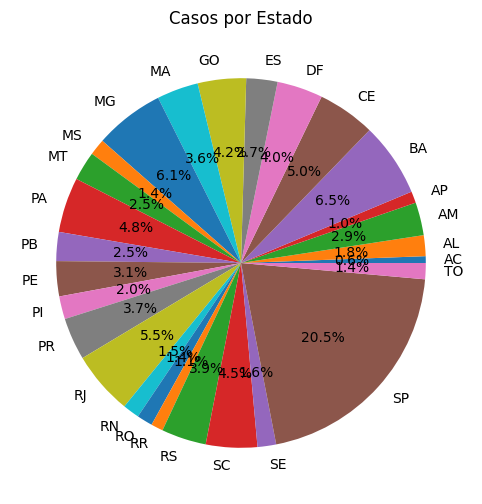

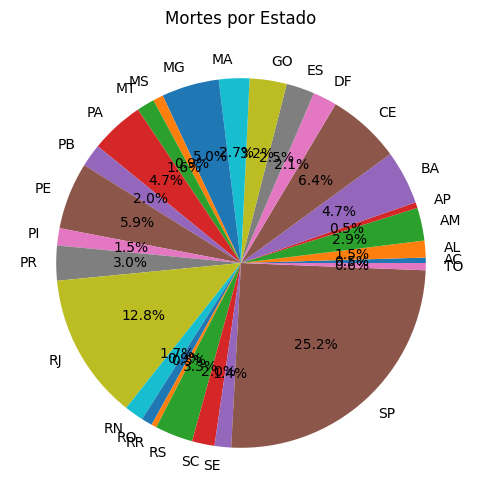

In [47]:
## Escolha

df = pd.DataFrame(casos_estado)

# Agrupando por UF e calculando a soma de casos e mortes
soma_casos = casos_estado["casos_estado"]
soma_mortes = casos_estado["mortes_estado"]

# Criando o gráfico pie para casos por estado
plt.figure(figsize=(8, 6))
plt.pie(soma_casos, labels=soma_casos.index, autopct='%1.1f%%')
plt.title('Casos por Estado')
plt.show()

# Criando o gráfico pie para mortes por estado
plt.figure(figsize=(8, 6))
plt.pie(soma_mortes, labels=soma_mortes.index, autopct='%1.1f%%')
plt.title('Mortes por Estado')
plt.show()